## Surrogate Assisted Evolutionary Algorithms for CNN Hyperparameter Optimization

### Imports

In [6]:
from util import AlexNet, SmallCNN, get_loaders, train_model

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### CNN Hyperparameters

In [7]:
# CNN Hyperparameters
DATA_DIR = '~/data'
DATASET = 'cifar'
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10
VALIDATION_TARGET = 100 # target validation accuracy
TRAIN_CONCURRENT = 6 # number of models to train concurrently
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data

In [8]:
# Get dataloaders
train_loader, valid_loader = get_loaders(data_dir=DATA_DIR, dataset=DATASET, batch_size=BATCH_SIZE, download=False)
model = SmallCNN().to(DEVICE)

# SGD optimizer - momentum, weight decay are the hyperparameters we are optimizing
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [9]:
# Train model
log_dict = train_model(model=model, 
                num_epochs=NUM_EPOCHS, 
                optimizer=optimizer, 
                device=DEVICE, 
                train_loader=train_loader, 
                valid_loader=valid_loader,
                valid_target=VALIDATION_TARGET,
                print_=True)

# Calculate fitness as a function of validation accuracy and number of batches trained
valid_acc = log_dict['valid_acc_per_epoch'][-1]
train_acc = log_dict['train_acc_per_epoch'][-1]
num_epochs_trained = log_dict['num_epochs_trained']

Epoch: 1/10 | Train Loss: 1.6951 | Train Acc: 42.44%
Epoch: 1/10 | Valid Loss: 1.7405 | Valid Acc: 41.20%
Epoch: 2/10 | Train Loss: 1.5154 | Train Acc: 51.17%
Epoch: 2/10 | Valid Loss: 1.6100 | Valid Acc: 48.83%
Epoch: 3/10 | Train Loss: 1.0314 | Train Acc: 63.45%
Epoch: 3/10 | Valid Loss: 1.1730 | Valid Acc: 59.67%
Epoch: 4/10 | Train Loss: 1.1445 | Train Acc: 61.83%
Epoch: 4/10 | Valid Loss: 1.3142 | Valid Acc: 57.40%
Epoch: 5/10 | Train Loss: 0.9453 | Train Acc: 66.82%
Epoch: 5/10 | Valid Loss: 1.1659 | Valid Acc: 61.05%
Epoch: 6/10 | Train Loss: 1.1712 | Train Acc: 62.36%
Epoch: 6/10 | Valid Loss: 1.4448 | Valid Acc: 57.76%
Epoch: 7/10 | Train Loss: 0.8247 | Train Acc: 71.81%
Epoch: 7/10 | Valid Loss: 1.1733 | Valid Acc: 63.98%
Epoch: 8/10 | Train Loss: 0.6115 | Train Acc: 77.86%
Epoch: 8/10 | Valid Loss: 0.9942 | Valid Acc: 68.18%
Epoch: 9/10 | Train Loss: 0.6937 | Train Acc: 75.87%
Epoch: 9/10 | Valid Loss: 1.1549 | Valid Acc: 66.90%
Epoch: 10/10 | Train Loss: 0.5127 | Train Acc:

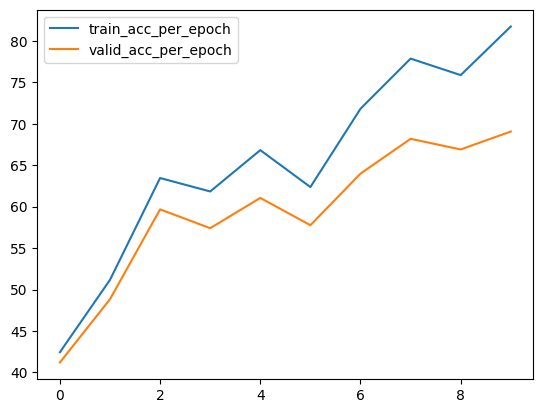

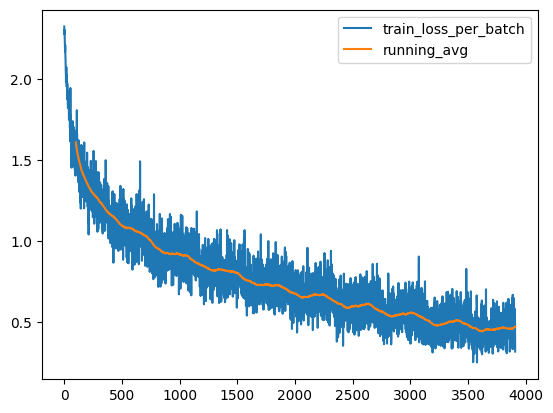

In [10]:
# plot training curves
plt.plot(log_dict['train_acc_per_epoch'], label='train_acc_per_epoch')
plt.plot(log_dict['valid_acc_per_epoch'], label='valid_acc_per_epoch')
plt.legend()
plt.show()


# create running average of loss per batch
avg_loss = []
for i in range(len(log_dict['train_loss_per_batch'])):
    avg_loss.append(np.mean(log_dict['train_loss_per_batch'][i-100:i+100]))

# plot loss per batch
plt.plot(log_dict['train_loss_per_batch'], label='train_loss_per_batch')
plt.plot(avg_loss, label='running_avg')
plt.legend()
plt.show()

In [78]:
loss_threshold = .5

# number of batches trained
print('Number of batches trained: {}'.format(len(log_dict['train_loss_per_batch'])))

# find batch where training loss is less than loss_threshold
for i, acc in enumerate(log_dict['train_loss_per_batch']):
    if acc < loss_threshold :
        break

tt_score = (1 - ((i+1) / len(log_dict['train_loss_per_batch'])))*100
print('Training loss first falls below {} at batch {}'.format(loss_threshold, tt_score))

Number of batches trained: 3910
Training loss first falls below 0.5 at batch 49.48849104859335


In [1]:
from es import *

mu = 10 # population size

# Initialize population creation
population = [Genome() for _ in range(mu)]

# Update fitnesses using multiprocessing   
x_values = [genome.x for genome in population]
with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
    results = list(tqdm(executor.map(fitness, population), total=len(population)))


 10%|█         | 1/10 [05:26<48:59, 326.65s/it]

In [ ]:
for i in range(len(population)):
    population[i].valid_acc = results[i][1]
    population[i].train_acc = results[i][2]
    population[i].train_loss = results[i][3]
    population[i].loss_target_fitness = results[i][4]


x: [8.64757992e-02 8.74341790e-01 2.67696530e-04], validation accuracy: 69.20999908447266, loss target fitness: 44.19437340153453, sigma: [8.64757992e-03 8.74341790e-02 2.67696530e-05]